In [1]:
from google.colab import files
uploaded = files.upload()


Saving fake_imdb_dataset.csv to fake_imdb_dataset.csv


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Yüklenen dosyayı oku
df = pd.read_csv("fake_imdb_dataset.csv")

# Küçük harfe çevir, alfasayısal olmayanları temizle
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

df['review'] = df['review'].apply(clean_text)
df['label'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)


In [5]:
import nltk
nltk.download('punkt')       # kelime tokenizasyonu için
nltk.download('stopwords')   # stopword'ler için (zaten kullanıyoruz)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
# Tokenize ve vocabulary oluştur
stop_words = set(stopwords.words('english'))
def tokenize(text):
    return [word for word in word_tokenize(text) if word not in stop_words]

vocab = {}
idx = 2  # 0 = PAD, 1 = UNK
for review in df['review']:
    for word in tokenize(review):
        if word not in vocab:
            vocab[word] = idx
            idx += 1

vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(text, max_len=100):
    tokens = tokenize(text)
    encoded = [vocab.get(t, 1) for t in tokens]
    if len(encoded) < max_len:
        encoded += [0] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded


In [11]:
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, max_len=100):
        self.reviews = [encode(r, max_len) for r in reviews]
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return torch.tensor(self.reviews[idx]), torch.tensor(self.labels[idx])

X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)
train_dataset = IMDBDataset(X_train.tolist(), y_train.tolist())
test_dataset = IMDBDataset(X_test.tolist(), y_test.tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [12]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Son zaman adımı
        out = self.fc(out)
        return self.sigmoid(out)


In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNClassifier(len(vocab), 64, 128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0211)

train_losses = []
for epoch in range(30):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 0.8322
Epoch 2, Loss: 0.5932
Epoch 3, Loss: 0.4436
Epoch 4, Loss: 0.4269
Epoch 5, Loss: 0.4439
Epoch 6, Loss: 0.4174
Epoch 7, Loss: 0.4030
Epoch 8, Loss: 0.3926
Epoch 9, Loss: 0.3827
Epoch 10, Loss: 0.3747
Epoch 11, Loss: 0.3822
Epoch 12, Loss: 0.4087
Epoch 13, Loss: 0.3974
Epoch 14, Loss: 0.3869
Epoch 15, Loss: 0.3926
Epoch 16, Loss: 0.3984
Epoch 17, Loss: 0.3808
Epoch 18, Loss: 0.3854
Epoch 19, Loss: 0.3899
Epoch 20, Loss: 0.3917
Epoch 21, Loss: 0.3824
Epoch 22, Loss: 0.3739
Epoch 23, Loss: 0.4106
Epoch 24, Loss: 0.3987
Epoch 25, Loss: 0.4080
Epoch 26, Loss: 0.3791
Epoch 27, Loss: 0.3927
Epoch 28, Loss: 0.4004
Epoch 29, Loss: 0.4114
Epoch 30, Loss: 0.4030


In [34]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = (outputs.cpu().numpy() > 0.5).astype(int)
        y_pred.extend(preds.flatten())
        y_true.extend(y_batch.numpy())

print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76        56
           1       0.68      0.82      0.74        44

    accuracy                           0.75       100
   macro avg       0.75      0.76      0.75       100
weighted avg       0.76      0.75      0.75       100

Confusion Matrix:
 [[39 17]
 [ 8 36]]


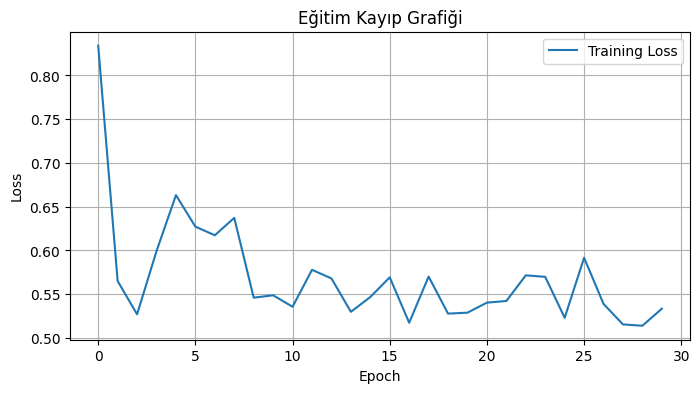

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim Kayıp Grafiği")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Sınıf dağılımını göster
print(df['sentiment'].value_counts())


sentiment
negative    250
positive    250
Name: count, dtype: int64


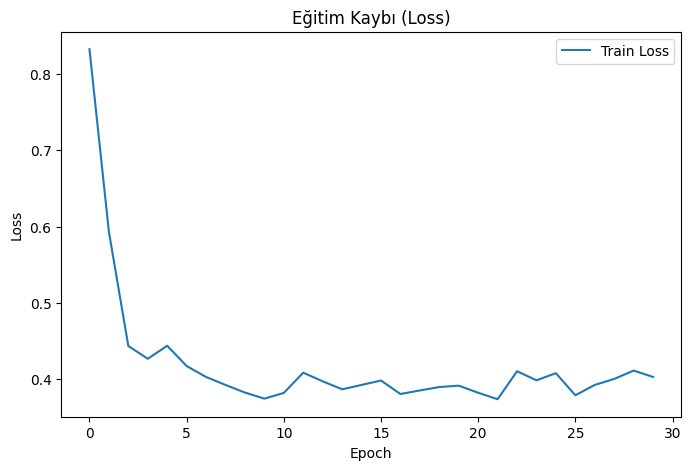

              precision    recall  f1-score   support

    Negative       0.83      0.70      0.76        56
    Positive       0.68      0.82      0.74        44

    accuracy                           0.75       100
   macro avg       0.75      0.76      0.75       100
weighted avg       0.76      0.75      0.75       100



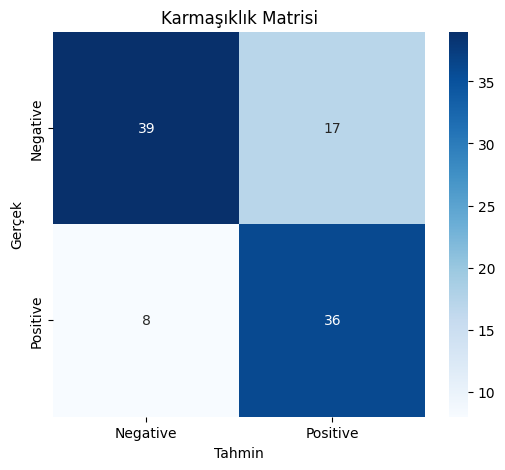

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Loss grafiği çizimi
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.title('Eğitim Kaybı (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tahminleri hesapla
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(x_batch)
        preds = (outputs > 0.5).int().cpu().numpy()
        y_pred.extend(preds.flatten())
        y_true.extend(y_batch.cpu().numpy())

# Sınıflandırma raporu
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

# Karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Karmaşıklık Matrisi')
plt.show()


In [37]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/30, Loss: 0.3834
Epoch 2/30, Loss: 0.3730
Epoch 3/30, Loss: 0.3791
Epoch 4/30, Loss: 0.3707
Epoch 5/30, Loss: 0.3719
Epoch 6/30, Loss: 0.3743
Epoch 7/30, Loss: 0.3714
Epoch 8/30, Loss: 0.3636
Epoch 9/30, Loss: 0.3671
Epoch 10/30, Loss: 0.3705
Epoch 11/30, Loss: 0.3668
Epoch 12/30, Loss: 0.3704
Epoch 13/30, Loss: 0.3677
Epoch 14/30, Loss: 0.3657
Epoch 15/30, Loss: 0.4404
Epoch 16/30, Loss: 0.3737
Epoch 17/30, Loss: 0.3696
Epoch 18/30, Loss: 0.3734
Epoch 19/30, Loss: 0.3695
Epoch 20/30, Loss: 0.3724
Epoch 21/30, Loss: 0.3706
Epoch 22/30, Loss: 0.3658
Epoch 23/30, Loss: 0.3665
Epoch 24/30, Loss: 0.3679
Epoch 25/30, Loss: 0.3689
Epoch 26/30, Loss: 0.3722
Epoch 27/30, Loss: 0.3660
Epoch 28/30, Loss: 0.3694
Epoch 29/30, Loss: 0.3648
Epoch 30/30, Loss: 0.3703


In [46]:
import torch
import torch.nn as nn

class TorchRNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1):
        super(TorchRNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Eğer binary classification ise

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_size)
        out, hidden = self.rnn(embedded)  # out: (batch_size, seq_len, hidden_size)
        out = out[:, -1, :]  # Son zaman adımının çıktısı
        out = self.fc(out)  # (batch_size, output_size)
        out = self.sigmoid(out)  # binary için 0-1 arası değer
        return out


import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TorchRNNClassifier(vocab_size=len(vocab), embed_size=64, hidden_size=128, output_size=1).to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x_batch, y_batch in train_loader:  # train_loader: torch DataLoader
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        predicted = (outputs > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/30 — Loss: 0.7926, Accuracy: 0.4950
Epoch 2/30 — Loss: 0.6968, Accuracy: 0.5350
Epoch 3/30 — Loss: 0.7181, Accuracy: 0.4800
Epoch 4/30 — Loss: 0.6964, Accuracy: 0.5000
Epoch 5/30 — Loss: 0.7056, Accuracy: 0.4800
Epoch 6/30 — Loss: 0.7004, Accuracy: 0.5250
Epoch 7/30 — Loss: 0.6921, Accuracy: 0.5350
Epoch 8/30 — Loss: 0.7169, Accuracy: 0.5150
Epoch 9/30 — Loss: 0.7139, Accuracy: 0.5050
Epoch 10/30 — Loss: 0.7009, Accuracy: 0.5100
Epoch 11/30 — Loss: 0.7025, Accuracy: 0.5100
Epoch 12/30 — Loss: 0.7023, Accuracy: 0.4750
Epoch 13/30 — Loss: 0.7317, Accuracy: 0.4850
Epoch 14/30 — Loss: 0.7123, Accuracy: 0.4900
Epoch 15/30 — Loss: 0.7282, Accuracy: 0.5050
Epoch 16/30 — Loss: 0.7174, Accuracy: 0.5050
Epoch 17/30 — Loss: 0.7228, Accuracy: 0.4550
Epoch 18/30 — Loss: 0.7091, Accuracy: 0.5100
Epoch 19/30 — Loss: 0.7093, Accuracy: 0.5450
Epoch 20/30 — Loss: 0.7108, Accuracy: 0.5250
Epoch 21/30 — Loss: 0.7332, Accuracy: 0.4700
Epoch 22/30 — Loss: 0.7159, Accuracy: 0.5250
Epoch 23/30 — Loss:

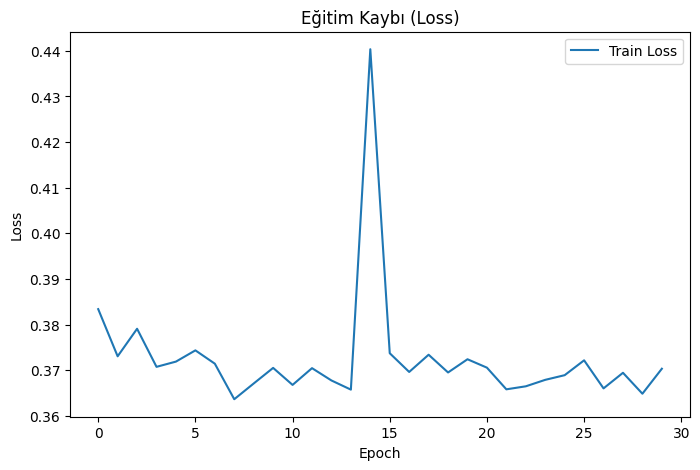

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        56
    Positive       0.44      1.00      0.61        44

    accuracy                           0.44       100
   macro avg       0.22      0.50      0.31       100
weighted avg       0.19      0.44      0.27       100



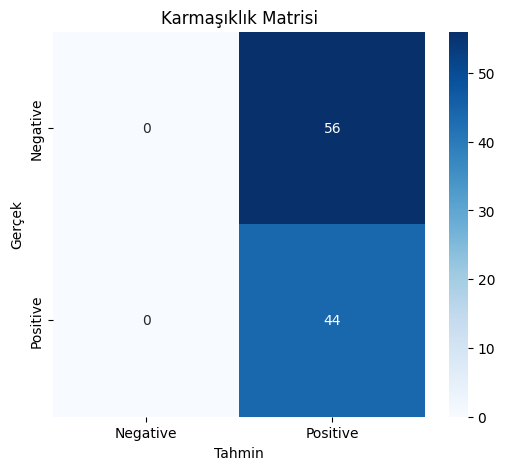

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Loss grafiği çizimi
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.title('Eğitim Kaybı (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tahminleri hesapla
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(x_batch)
        preds = (outputs > 0.5).int().cpu().numpy()
        y_pred.extend(preds.flatten())
        y_true.extend(y_batch.cpu().numpy())

# Sınıflandırma raporu
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

# Karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Karmaşıklık Matrisi')
plt.show()
